In [42]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.draw import polygon_perimeter

from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.light_source import LightSource
from spice import solve_quasi_3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
contactsMask = imread('masks_sq.png')

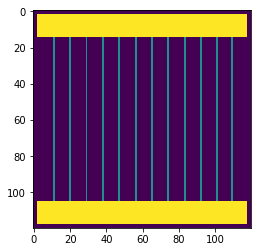

In [44]:
plt.imshow(contactsMask)

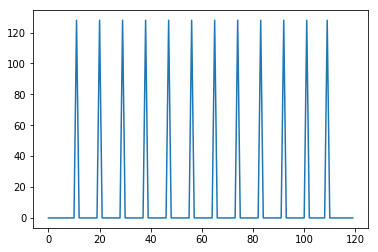

In [45]:
plt.plot(contactsMask[50,:])

In [57]:
rl=12
rh=22
cl=55
ch=65
small_tile=contactsMask[rl:rh,cl:ch]

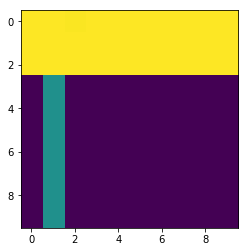

In [58]:
plt.imshow(small_tile)

In [59]:
rr,cc=polygon_perimeter([rl,rl,rh,rh],[cl,ch,ch,cl],shape=contactsMask.shape)

In [60]:
cc

array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 65, 65, 65, 65, 65, 65,
       65, 65, 65, 65, 65, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55])

In [61]:
annote=np.zeros((*contactsMask.shape,3))
print(annote.shape)
annote[rr,cc,0]=255

(120, 120, 3)


In [62]:
color_contactsmask=np.stack((contactsMask,contactsMask,contactsMask),axis=2)

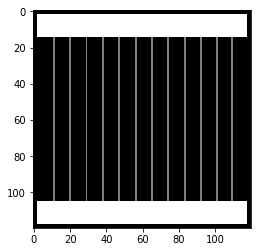

In [63]:
plt.imshow(color_contactsmask)

In [64]:
color_contactsmask[rr,cc,0]=255
color_contactsmask[rr,cc,1]=0
color_contactsmask[rr,cc,2]=0

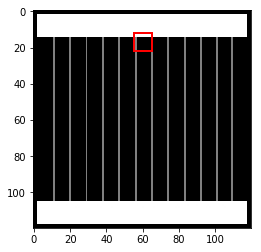

In [65]:
plt.imshow(color_contactsmask)

In [67]:
color_small_tile=color_contactsmask[rl:rh,cl:ch,:]

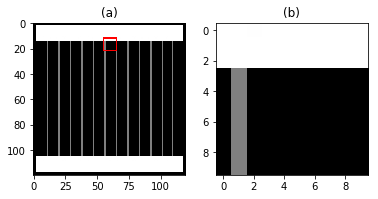

In [72]:
fig,ax=plt.subplots(ncols=2,nrows=1)
ax[0].imshow(color_contactsmask)
ax[0].set_title("(a)")
ax[1].imshow(np.stack((small_tile,small_tile,small_tile),axis=2))
ax[1].set_title("(b)")

plt.savefig("./doc_images/merge_pixel_demo.png",dpi=150)

In [56]:
small_tile

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 254, 255, 255, 255, 255],
       [255, 255, 254, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [  0, 128,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 128,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 128,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 128,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 128,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=uint8)

assume that resistance of each pixel is 1

### Add up y-axis

In [12]:
r_mask=np.where(small_tile>50,1,0)

In [13]:
col_sum=np.sum(r_mask,axis=1)

In [14]:
unit_r=1
r_value=1/np.sum(1/(col_sum*unit_r))
print(r_value)

0.1


### Add up x-axis

In [15]:
row_sum=np.sum(r_mask,axis=0)
row_sum

array([ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0])

In [16]:
unit_r=10
row_sum_mask=np.where(row_sum==0,np.inf,0)
print(row_sum_mask)
row_sum=row_sum_mask+row_sum
print(row_sum)
r_value=1/np.sum(1/((row_sum)*unit_r))
print(r_value)

[inf  0. inf inf inf inf inf inf inf inf]
[inf 10. inf inf inf inf inf inf inf inf]
100.0


In [17]:
from spice.dynamic_pixel import get_pixel_r

In [18]:
get_pixel_r(np.array([[100]]),1,1,threshold=50)

(1.0, 1.0, 1.0)

In [19]:
get_pixel_r(small_tile,1,1,50)

(0.1, 10.0, 0.1)

In [20]:
np.linspace(0,20,7,dtype=np.int,endpoint=False)

array([ 0,  2,  5,  8, 11, 14, 17])

In [21]:
np.arange(0,20,1,dtype=np.int)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [22]:
image=contactsMask
rw=5
cw=5
ri=np.arange(0,image.shape[0],rw,dtype=np.int)
ci=np.arange(0,image.shape[1],cw,dtype=np.int)

agg_image=np.zeros((ri.shape[0],ci.shape[0]))
for rii in np.arange(0,ri.shape[0],1):
    for cii in np.arange(0,ci.shape[0],1):
        if (rii+1) < ri.shape:
            end_ri=ri[rii+1]
        else:
            end_ri=image.shape[0]
        
        if (cii+1) < ci.shape:
            end_ci=ci[cii+1]
        else:
            end_ci=image.shape[1]
                
        tile=image[ri[rii]:end_ri,ci[cii]:end_ci]
        agg_image[rii,cii]=np.sum(tile)


In [23]:
image=contactsMask
rw=5
cw=5
ri=np.arange(0,image.shape[0],rw,dtype=np.int)
ci=np.arange(0,image.shape[1],cw,dtype=np.int)

ri=np.concatenate((ri,[image.shape[0]]))
ci=np.concatenate((ci,[image.shape[0]]))

agg_image=np.zeros((ri.shape[0],ci.shape[0]))

for rii in np.arange(0,ri.shape[0]-1,1):
    for cii in np.arange(0,ci.shape[0]-1,1):

        end_ri=ri[rii+1]
  
        end_ci=ci[cii+1]
              
        tile=image[ri[rii]:end_ri,ci[cii]:end_ci]
        agg_image[rii,cii]=np.sum(tile)

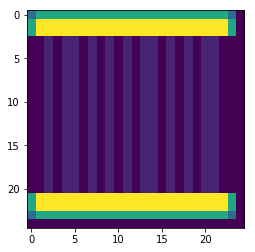

In [24]:
plt.imshow(agg_image)

In [25]:
from spice.dynamic_pixel import iterate_sub_image

In [26]:
sub_image_coord=iterate_sub_image(contactsMask,5,5)

In [27]:
agg_image=np.zeros((sub_image_coord.shape[0],sub_image_coord.shape[1]))

In [28]:
for i in range(sub_image_coord.shape[0]):
    for j in range(sub_image_coord.shape[1]):
        a,b,c,d=sub_image_coord[i,j,:]
        agg_image[i,j]=np.sum(contactsMask[a:b,c:d])

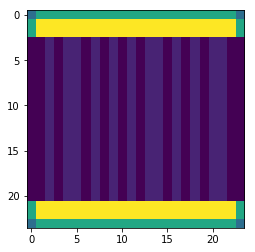

In [29]:
plt.imshow(agg_image)